In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import math
from scipy.stats import pearsonr
Current_Date = datetime.date.today()


# Set current date to day the code is run
Current_Date = datetime.date.today()


# setting tickers to the tickers we are using 
    # SPY = SP500 , QQQ = NASDAQ, ^VIX = SP500 Volatility Index
tickers = ['SPY', 'QQQ', '^VIX', '^IXIC'] 



# choose a starting date, ending date will be the day the code is run
start_date = '2018 - 02 - 10'
end_date = Current_Date


# retreive data using Pandas Datareader using Yahoo Finance (includes Date, Adj Close, Close, High, Low, Open, Volume)
panel_data = data.DataReader(tickers, 'yahoo', start_date,end_date)


# select and reassign only the ticker's open and close values to 'opens' and 'close' respectivly 
close = panel_data['Close']
opens = panel_data['Open']


# select frequency of stocks (change at end of "all_weekdays.. line below)
# Currently on Monthly
    # 'B' = get stock data Daily (business daily)
    # 'W-FRI' = once a week (on fridays)
    # 'SM' = semimonthly
    # 'BM' = monthly (business monthly)
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='W-Fri')


# this reindexes the closes and opens to the date range specified
# this also removes any 'NaN' values (comes from dividend or splits that are included on Yahoo Finance or starting date being a nonbusiness day after choosing business days)
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill')
opens = opens.reindex(all_weekdays)
opens = opens.fillna(method='ffill')




# assign variable index1 as the closing values of ticker = '___' 
    # currently = QQQ (the NASDAQ)
index1 = close.loc[all_weekdays, 'QQQ'] 
vix = close.loc[all_weekdays, '^VIX'] 


# Create the figure (not plotting yet)
fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")
# plt.ylim(0.9*min(spy),1.1*max(spy))
# plt.yscale('log')





####
#####  Solving GBM (St) by assigning constants, randoms, and Brownian motion (Bt)
####

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 

# interval of 1 day/month/week..
dt = 1  


# set inital stock price
S0 = index1[0]


# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
vixreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
    vixreturns.append(((vix[i] - vix[i-1]) / vix[i-1]))
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))


# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)


# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)
    
St1 = []
St1.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    # recall that we are using the fact that VIX typically moves opposite of the index to guess the direction
    # since we are not currently trying to predict we are using vireturnsx[i] because using vixreturns[i-1] could be using yesterdays move to predict the index's movement for today, we just want to see if the index moves like a GBM
    if vixreturns[i] > -0.01:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] - sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    else:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] + sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    
St2 = []
St2.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((mu - ((bt[i]**2)/2))*t[i] + bt[i]*(randbt[i]*math.sqrt(dt))))
    St2.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM = {}".format(round(pearsonr0,6)))
pearsonr1, _ = pearsonr(St1, index1)
print("r correlation GBM VIX = {}".format(round(pearsonr1,6)))
pearsonr2, _ = pearsonr(St2, index1)
print("r correlation GBM Martingale = {}".format(round(pearsonr2,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
ax.plot(t, vix+100, label='VIX ', color = 'blue', linewidth = 5)
ax.plot(t, St1, label='GBM VIX', color = 'green', linewidth = 5)
ax.plot(t, St2, label='GBM Martingale', color = 'cyan', linewidth = 5)
plt.legend()


# END


MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))


/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'SPY', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'QQQ', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '^VIX', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.7/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: '^IXIC', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


RemoteDataError: ignored

GBM 30 days

r correlation GBM = 0.910534


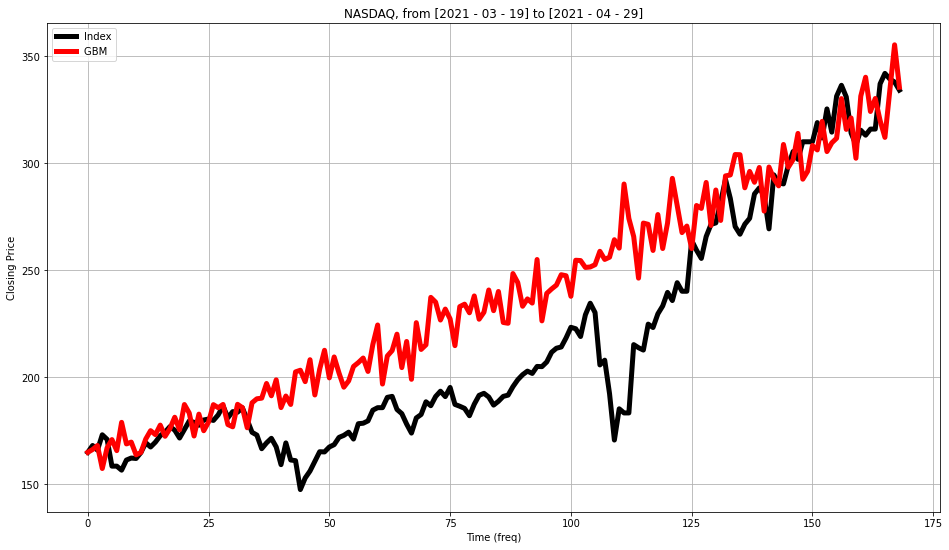

In [ ]:
start_date = '2021 - 03 - 19'
end_date = '2021 - 04 - 29'

all_weekdays = pd.date_range(start=start_date, end=end_date, freq='BM')

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM = {}".format(round(pearsonr0,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
plt.legend()


GBM 60 weeks

r correlation GBM = 0.895157


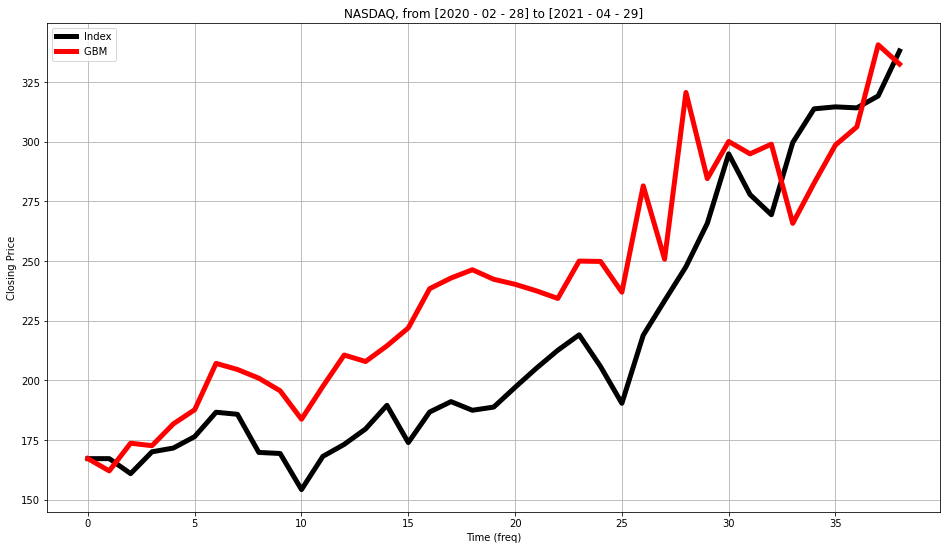

In [ ]:
start_date = '2020 - 02 - 28'
end_date = '2021 - 04 - 29'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM = {}".format(round(pearsonr0,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

GBM 100 weeks

r correlation GBM = 0.925789


ValueError: ignored

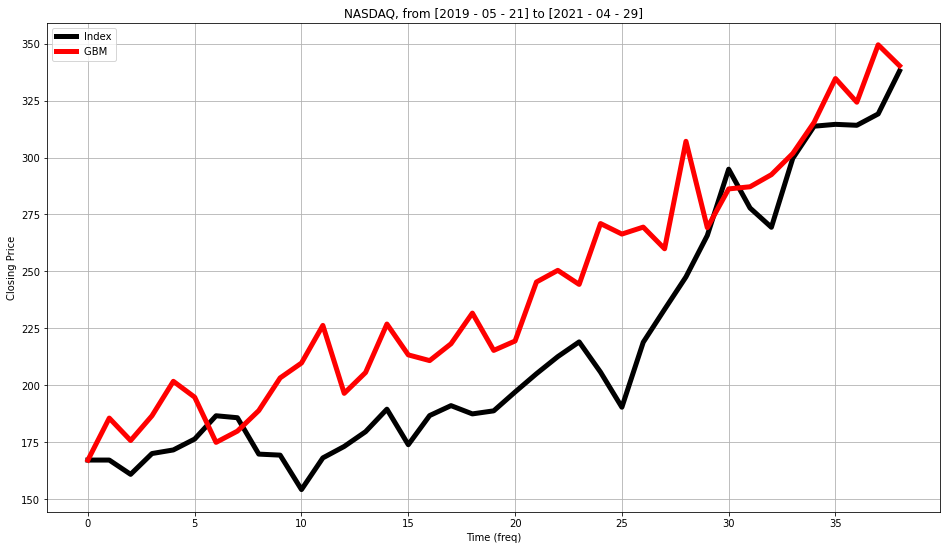

In [ ]:
start_date = '2019 - 05 - 21'
end_date = '2021 - 04 - 29'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM = {}".format(round(pearsonr0,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

GBM 100 months

r correlation GBM = 0.904227
 MAPE mean = 0.108482


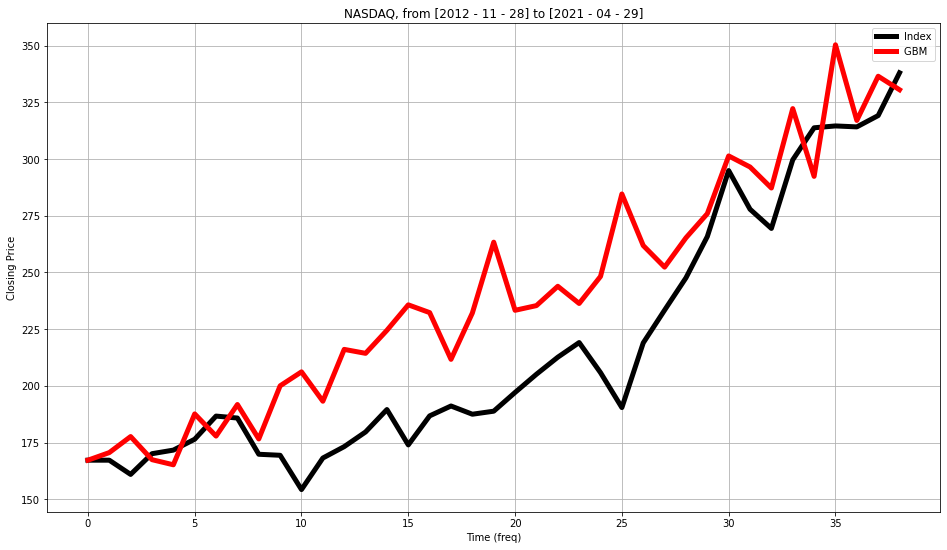

In [ ]:
start_date = '2012 - 11 - 28'
end_date = '2021 - 04 - 29'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM = {}".format(round(pearsonr0,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

3 GBM walks on 60 months

r correlation GBM 1 = 0.916278
r correlation GBM 2 = 0.87794
r correlation GBM 3 = 0.888494
 MAPE mean = 0.100066


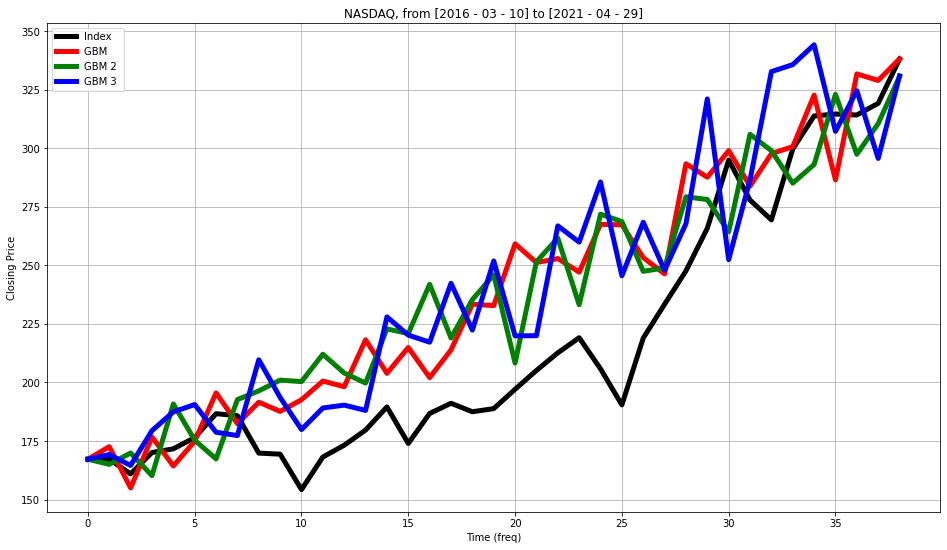

In [ ]:
start_date = '2016 - 03 - 10'
end_date = '2021 - 04 - 29'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

randbt1 = np.random.normal(0,1, size = (len(dailyreturns)))

St1 = []
St1.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt1[i]*math.sqrt(dt))))
    St1.append(s)
    
randbt2 = np.random.normal(0,1, size = (len(dailyreturns)))

St2 = []
St2.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt2[i]*math.sqrt(dt))))
    St2.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM 1 = {}".format(round(pearsonr0,6)))
pearsonr1, _ = pearsonr(St1, index1)
print("r correlation GBM 2 = {}".format(round(pearsonr1,6)))
pearsonr2, _ = pearsonr(St2, index1)
print("r correlation GBM 3 = {}".format(round(pearsonr2,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
ax.plot(t, St1, label='GBM 2', color = 'green', linewidth = 5)
ax.plot(t, St2, label='GBM 3 ', color = 'blue', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

3 GBM walks on 100 months

r correlation GBM 1 = 0.919083
r correlation GBM 2 = 0.883395
r correlation GBM 3 = 0.901717
 MAPE mean = 0.095415


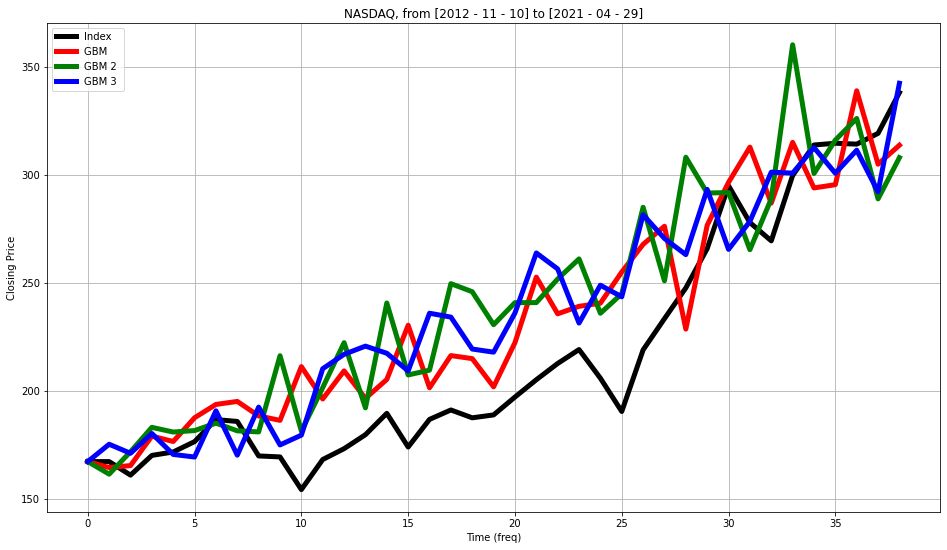

In [ ]:
start_date = '2012 - 11 - 10'
end_date = '2021 - 04 - 29'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)

randbt1 = np.random.normal(0,1, size = (len(dailyreturns)))

St1 = []
St1.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt1[i]*math.sqrt(dt))))
    St1.append(s)
    
randbt2 = np.random.normal(0,1, size = (len(dailyreturns)))

St2 = []
St2.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt2[i]*math.sqrt(dt))))
    St2.append(s)

#####

pearsonr0, _ = pearsonr(St, index1)
print("r correlation GBM 1 = {}".format(round(pearsonr0,6)))
pearsonr1, _ = pearsonr(St1, index1)
print("r correlation GBM 2 = {}".format(round(pearsonr1,6)))
pearsonr2, _ = pearsonr(St2, index1)
print("r correlation GBM 3 = {}".format(round(pearsonr2,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St, label='GBM ', color = 'red', linewidth = 5)
ax.plot(t, St1, label='GBM 2', color = 'green', linewidth = 5)
ax.plot(t, St2, label='GBM 3 ', color = 'blue', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

QQQ GBM with VIX adjustments over 100 weeks

r correlation GBM VIX = 0.887342
 MAPE mean = 0.117954


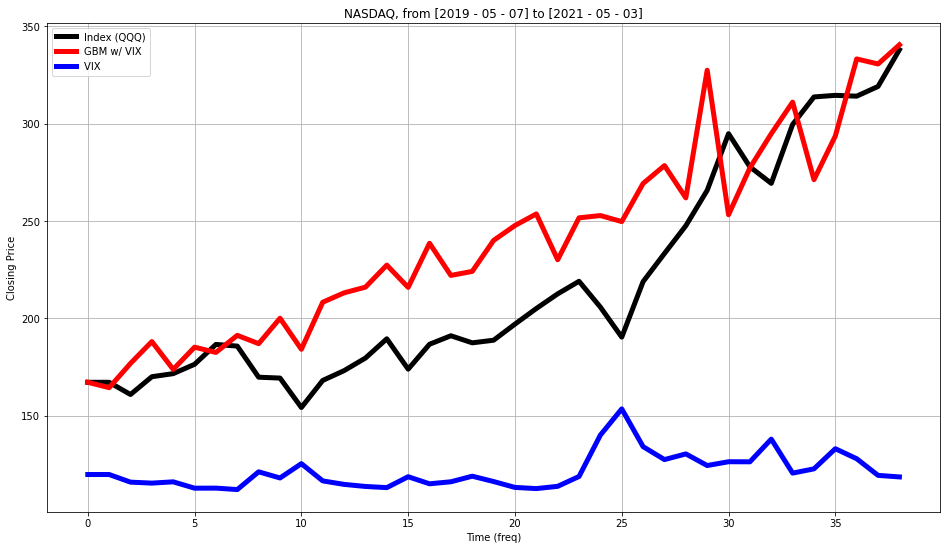

In [ ]:
start_date = '2019 - 05 - 07'
end_date = '2021 - 05 - 03'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
vixreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
    vixreturns.append(((vix[i] - vix[i-1]) / vix[i-1]))
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)
    
St1 = []
St1.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    # recall that we are using the fact that VIX typically moves opposite of the index to guess the direction
    # since we are not currently trying to predict we are using vireturnsx[i] because using vixreturns[i-1] could be using yesterdays move to predict the index's movement for today, we just want to see if the index moves like a GBM
    if vixreturns[i] > -0.01:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] - sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    else:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] + sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    
St2 = []
St2.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((mu - ((bt[i]**2)/2))*t[i] + bt[i]*(randbt[i]*math.sqrt(dt))))
    St2.append(s)

#####

pearsonr1, _ = pearsonr(St1, index1)
print("r correlation GBM VIX = {}".format(round(pearsonr1,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index (QQQ)', color = 'black', linewidth = 5)
ax.plot(t, St1, label='GBM w/ VIX', color = 'red', linewidth = 5)
ax.plot(t, vix+100, label='VIX ', color = 'blue', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St1, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))

QQQ GBM with Martingale over 100 weeks

r correlation GBM Martingale = 0.877125
 MAPE mean = 0.117079


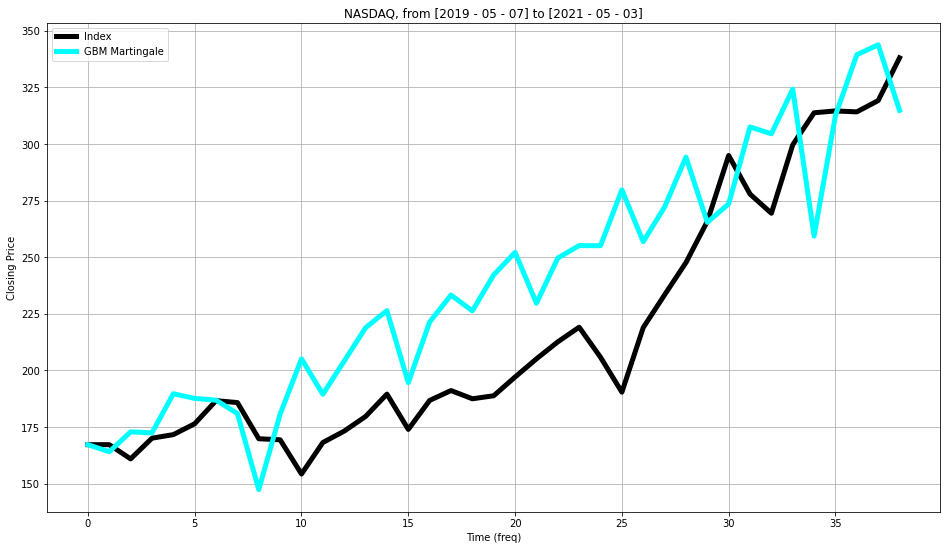

In [ ]:
start_date = '2019 - 05 - 07'
end_date = '2021 - 05 - 03'

fig, ax = plt.subplots(figsize=(16,9),facecolor=('white'))
plt.grid(True)
plt.title("NASDAQ, from [{}] to [{}]".format(start_date,end_date))
plt.xlabel("Time (freq)")
plt.ylabel("Closing Price")

# create a array for number of days for length of Stock data = start_date to end_date, this is our independent variable time
t= np.arange(len(index1)) 
# set inital stock price
S0 = index1[0]

# finding the drift using returns over designated time interval from data [constant] [average and s.d. of stock/index returns for frequency]
# create array named dailyreturns to hold each days move as a decimal 
dailyreturns = []
vixreturns = []
for i in range(1,index1.size):
    dailyreturns.append(((index1[i] - index1[i-1]) / index1[i-1]) )
    vixreturns.append(((vix[i] - vix[i-1]) / vix[i-1]))
mu = np.mean(dailyreturns)  
    # = sum(dailyreturns)/len(dailyreturns)

sigma = np.std(dailyreturns) 
    # = math.sqrt(sdt/(len(dailyreturns)-1)), where 

drift = (mu - ((sigma*sigma)/2))

# for Wiener process, need randomly generated numbers from normal distribution [randbt]
# randbt is this random array    [np.random.seed() gives random z with distribution of N(0,1)]
randbt = np.random.normal(0,1, size = (len(dailyreturns)))

bt = []
bt.append(1)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((0 - ((sigma*sigma)/2))*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    bt.append((s/S0)-1) # subtracting 1 and dividing by S0 gives an output that is between [0,1] (will be martingale - will revert sum towards 0)

    
#replace the beginning articifal 1 with something arbitrary
bt[0] = np.mean(bt)

# now we have everything for the GBM (St), 
# finding and assigning St motion [where Wt (Wiener Process) = randbt[i]*sqrt(dt)]
St = []
St.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp(drift*t[i] + sigma*(randbt[i]*math.sqrt(dt))))
    St.append(s)
    
St1 = []
St1.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    # recall that we are using the fact that VIX typically moves opposite of the index to guess the direction
    # since we are not currently trying to predict we are using vireturnsx[i] because using vixreturns[i-1] could be using yesterdays move to predict the index's movement for today, we just want to see if the index moves like a GBM
    if vixreturns[i] > -0.01:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] - sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    else:
        s = S0*(math.exp((mu - ((sigma*sigma)/2))*t[i] + sigma*(abs(randbt[i])*math.sqrt(dt))))
        St1.append(s)
    
St2 = []
St2.append(S0)
for i in range(0, len(dailyreturns)):     
    # Let s be a random variable = 0 at each iteration
    s = S0*(math.exp((mu - ((bt[i]**2)/2))*t[i] + bt[i]*(randbt[i]*math.sqrt(dt))))
    St2.append(s)

#####

pearsonr2, _ = pearsonr(St2, index1)
print("r correlation GBM Martingale = {}".format(round(pearsonr2,6)))

# Plot GBM and the Index, add legend to plot
ax.plot(t, index1, label='Index', color = 'black', linewidth = 5)
ax.plot(t, St2, label='GBM Martingale', color = 'cyan', linewidth = 5)
plt.legend()

MAPE_table = pd.DataFrame(index=all_weekdays)
MAPE_table['Actual'] = pd.Series(St2, index=all_weekdays)
MAPE_table['Forecast'] = pd.Series(index1)
MAPE_table['MAPE'] = abs((MAPE_table['Actual']-MAPE_table['Forecast'])/MAPE_table['Actual'])
print(" MAPE mean = {}".format(round(MAPE_table['MAPE'].mean(),6)))